In [1]:
import pyro.distributions as dist
from pyro import sample
from torch import tensor

# A fair coin
coinflip = sample("coinflip", dist.Bernoulli(probs=0.5))
print('coinflip', coinflip)

# A noisy sample
noisy_sample = sample("noisy_sample", dist.Normal(loc=0, scale=1))
print('noisy_sample', noisy_sample)

coinflip tensor(1.)
noisy_sample tensor(1.9914)


In [2]:
# Evaluating probability of values under distributiosn
print('X ~ B(0.5), P(X = 0): {:.2f}'.format(
    dist.Bernoulli(0.5).log_prob(tensor(0.)).exp()))
print('X ~ N(0, 1), P(X = 0.35): {:.2f}'.format(
    dist.Normal(0, 1).log_prob(tensor(0.35)).exp()))

X ~ B(0.5), P(X = 0): 0.50
X ~ N(0, 1), P(X = 0.35): 0.38


In [4]:
def sleep_model():
    # Very likely to feel lazy
    feeling_lazy = sample("feeling_lazy", dist.Bernoulli(0.9))
    if feeling_lazy:
        # Only going to (possibly) ignore my alarm if I'm feeling lazy
        ignore_alarm = sample("ignore_alarm", dist.Bernoulli(0.8))
        # Will sleep more if I ignore my alarm
        amount_slept = sample("amount_slept",
                              dist.Normal(8 + 2 * ignore_alarm, 1))
    else:
        amount_slept = sample("amount_slept", dist.Normal(6, 1))
    return amount_slept

print(sleep_model())
print(sleep_model())
print(sleep_model())

tensor(10.3261)
tensor(6.5516)
tensor(9.4153)


In [5]:
from random import random

class Bernoulli:
    def __init__(self, p):
        self.p = p
        
    def sample(self):
        # random() is uniform between [0, 1]
        if random() < self.p:
            return tensor(1.)
        else:
            return tensor(0.)
        
    def log_prob(self, x):
        # This formulation is differentiable!
        return (x * self.p + (1 - x) * (1 - self.p)).log()
    
b = Bernoulli(0.8)
print('x ~ P_b:', b.sample())
print('P_b(0):', b.log_prob(tensor(0.)).exp())

x ~ P_b: tensor(1.)
P_b(0): tensor(0.2000)


In [6]:
from pyro.poutine import trace
from pprint import pprint

# Runs the sleep model once and collects a trace
tr = trace(sleep_model).get_trace()

pprint({
    name: {
        'value': props['value'],
        'prob': props['fn'].log_prob(props['value']).exp()
    }
    for (name, props) in tr.nodes.items()
    if props['type'] == 'sample'
})

print(tr.log_prob_sum().exp()) 

{'amount_slept': {'prob': tensor(0.3482), 'value': tensor(10.5216)},
 'feeling_lazy': {'prob': tensor(0.9000), 'value': tensor(1.)},
 'ignore_alarm': {'prob': tensor(0.8000), 'value': tensor(1.)}}
tensor(0.2507)


In [7]:
from pyro import condition

cond_model = condition(sleep_model, {
    "feeling_lazy": tensor(1.),
    "ignore_alarm": tensor(0.),
    "amount_slept": tensor(10.)
})

trace(cond_model).get_trace().log_prob_sum().exp()

tensor(0.0097)

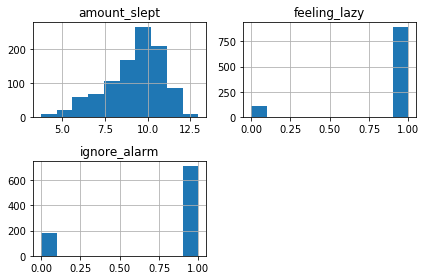

In [8]:
import matplotlib.pyplot as plt
import pandas as pd

traces = []
for _ in range(1000):
    tr = trace(sleep_model).get_trace()
    values = {
        name: props['value'].item()
        for (name, props) in tr.nodes.items()
        if props['type'] == 'sample'
    }
    traces.append(values)

pd.DataFrame(traces).hist()
plt.tight_layout()

In [9]:
norm = dist.Normal(0, 1)
x = sample("x", norm)
print(x)

tensor(-0.5752)


In [10]:
from pyro import param

mu = param("mu", tensor(0.))
norm = dist.Normal(mu, 1)
x = sample("x", norm)
print(mu, x)

tensor(0., requires_grad=True) tensor(-0.5113, grad_fn=<AddBackward0>)


In [11]:
prob = norm.log_prob(5)
print('Initial prob:', prob, prob.exp())

prob.backward() # Compute gradients with respect to probability

print('mu:', mu)
print('d mu / d prob:', mu.grad) # 5.0
mu.data += mu.grad # Manually take gradient step

print('Final prob:', dist.Normal(mu, 1).log_prob(5).exp()) 
print('Final mu:', mu)

Initial prob: tensor(-13.4189, grad_fn=<SubBackward0>) tensor(1.4867e-06, grad_fn=<ExpBackward>)
mu: tensor(0., requires_grad=True)
d mu / d prob: tensor(5.)
Final prob: tensor(0.3989, grad_fn=<ExpBackward>)
Final mu: tensor(5., requires_grad=True)


In [12]:
from pyro import clear_param_store

# Note: params are persistent, so we have to manually reset the global Pyro parameter store
# to avoid caching results between experiments
clear_param_store()

def model():
    mu = param("mu", tensor(0.))
    return sample("x", dist.Normal(mu, 1))

cond_model = condition(model, {"x": 5})
tr = trace(cond_model).get_trace()
tr.log_prob_sum().backward()

mu = param("mu")
mu.data += mu.grad
print('Final mu:', mu)

Final mu: tensor(5., requires_grad=True)


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002360AE27550>,
      dtype=object)

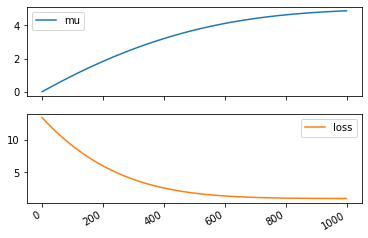

In [13]:
from torch.optim import Adam

clear_param_store()

def model():
    mu = param("mu", tensor(0.))
    return sample("x", dist.Normal(mu, 1))

model() # Instantiate the mu parameter
cond_model = condition(model, {"x": 5})

# Large learning rate for demonstration purposes
optimizer = Adam([param("mu")], lr=0.01)
mus = []
losses = []
for _ in range(1000):
    tr = trace(cond_model).get_trace()

    # Optimizer wants to push positive values towards zero,
    # so use negative log probability
    prob = -tr.log_prob_sum()
    prob.backward()

    # Update parameters according to optimization strategy
    optimizer.step()

    # Zero all parameter gradients so they don't accumulate
    optimizer.zero_grad()

    # Record probability (or "loss") along with current mu
    losses.append(prob.item())
    mus.append(param("mu").item())

pd.DataFrame({"mu": mus, "loss": losses}).plot(subplots=True)

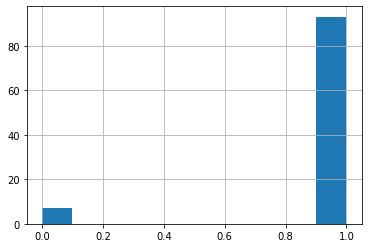

In [14]:
# Condition model on observed data
underslept = condition(sleep_model, {"amount_slept": 6.})

# Draw samples from conditioned model?
pd.Series(
    [trace(underslept).get_trace().nodes['feeling_lazy']['value'].item()
    for _ in range(100)]) \
    .hist()

In [15]:
def sleep_guide():
    sample("feeling_lazy", dist.Delta(tensor(1.)))
    sample("ignore_alarm", dist.Delta(tensor(0.)))

trace(sleep_guide).get_trace().nodes['feeling_lazy']['value']

tensor(1.)

In [16]:
import torch

def elbo(guide, cond_model):
    dist = 0.
    for fl in [0., 1.]:
        for ia in [0., 1.] if fl == 1. else [0.]:
            log_prob = lambda f: trace(condition(
                f, {"feeling_lazy": tensor(fl), "ignore_alarm": tensor(ia)})) \
                .get_trace().log_prob_sum()
            guide_prob = log_prob(guide)
            cond_model_prob = log_prob(cond_model)
            term = guide_prob.exp() * (cond_model_prob - guide_prob)
            if not torch.isnan(term):
                dist += term
    return dist

elbo(sleep_guide, underslept)

tensor(-4.6337)

In [17]:
def sleep_guide2():
    sample("feeling_lazy", dist.Delta(tensor(0.)))
    sample("ignore_alarm", dist.Delta(tensor(0.)))

elbo(sleep_guide2, underslept)

tensor(-3.2215)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000023611010910>,
      dtype=object)

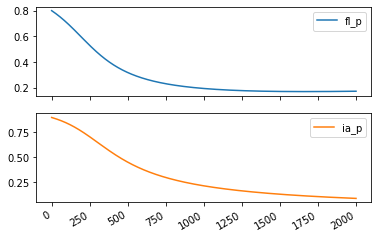

In [18]:
from torch.distributions import constraints
clear_param_store()

def sleep_guide():
    # Constraints ensure facts always remain true during optimization,
    # e.g. that the parameter of a Bernoulli is always between 0 and 1
    valid_prob = constraints.interval(0., 1.)
    fl_p = param('fl_p', tensor(0.8), constraint=valid_prob)
    ia_p = param('ia_p', tensor(0.9), constraint=valid_prob)
    feeling_lazy = sample('feeling_lazy', dist.Bernoulli(fl_p))

    # Consistent with the model, we only sample ignore_alarm if
    # feeling_lazy is true
    if feeling_lazy == 1.:
        sample('ignore_alarm', dist.Bernoulli(ia_p))
sleep_guide()

adam = Adam([param('fl_p').unconstrained(), param('ia_p').unconstrained()],
            lr=0.005, betas=(0.90, 0.999))
param_vals = []

for _ in range(2000):
    # We can use our elbo function from earlier and compute its gradient
    loss = -elbo(sleep_guide, underslept)
    loss.backward()

    adam.step()
    adam.zero_grad()

    param_vals.append({k: param(k).item() for k in ['fl_p', 'ia_p']})

pd.DataFrame(param_vals).plot(subplots=True)

In [21]:
from pyro.poutine import replay

def elbo_approx(guide, cond_model):
    guide_trace = trace(guide).get_trace()
    model_trace = trace(replay(cond_model, guide_trace)).get_trace()
    return model_trace.log_prob_sum() - guide_trace.log_prob_sum()

In [22]:
def optimize_guide(elbo):
    clear_param_store()
    sleep_guide()

    adam = Adam([param('fl_p').unconstrained(), param('ia_p').unconstrained()],
                lr=0.005, betas=(0.90, 0.999))
    param_vals = []
    grad_vals = []

    for _ in range(2000):
        # We can use our elbo function from earlier and compute its gradient
        loss = -elbo(sleep_guide, underslept)
        loss.backward()
        grad_vals.append(param('fl_p').unconstrained().grad.item())

        adam.step()
        adam.zero_grad()

        param_vals.append({k: param(k).item() for k in ['fl_p', 'ia_p']})
        
    return param_vals, grad_vals

Parameters for true ELBO


array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000236111122B0>,
      dtype=object)

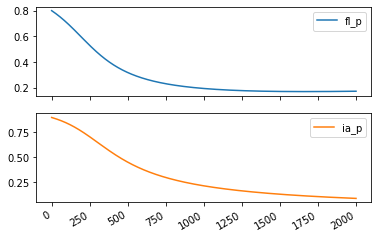

In [23]:
true_param_vals, true_grad_vals = optimize_guide(elbo)
print('Parameters for true ELBO')
pd.DataFrame(true_param_vals).plot(subplots=True)

Gradient for true ELBO


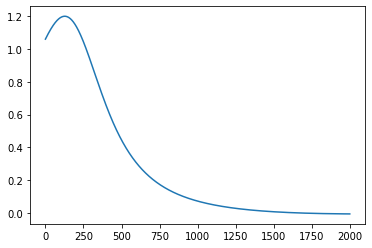

In [24]:
print('Gradient for true ELBO')
pd.Series(true_grad_vals).plot()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000023611315D90>,
      dtype=object)

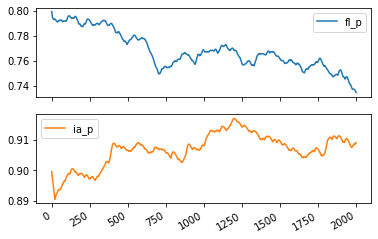

In [25]:
approx_param_vals, approx_grad_vals = optimize_guide(elbo_approx)
pd.DataFrame(approx_param_vals).plot(subplots=True)

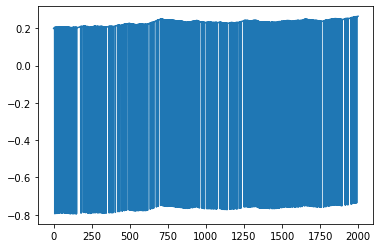

In [26]:
pd.Series(approx_grad_vals).plot()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002360AD79760>,
      dtype=object)

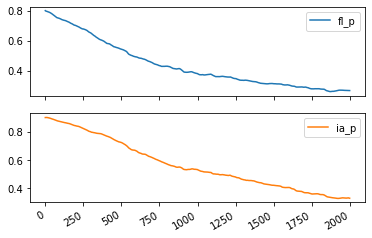

In [27]:
def elbo_better_approx(guide, cond_model):
    guide_trace = trace(guide).get_trace()
    model_trace = trace(replay(cond_model, guide_trace)).get_trace()
    elbo = model_trace.log_prob_sum() - guide_trace.log_prob_sum()
    # "detach" means "don't compute gradients through this expression"
    return guide_trace.log_prob_sum() * elbo.detach() + elbo

better_approx_param_vals, better_approx_grad_vals = optimize_guide(elbo_better_approx)
pd.DataFrame(better_approx_param_vals).plot(subplots=True)

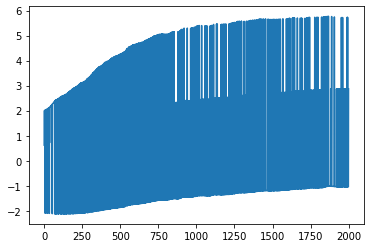

In [28]:
pd.Series(better_approx_grad_vals).plot()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002360AD23970>,
      dtype=object)

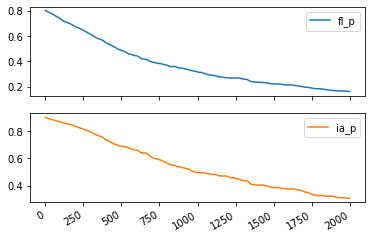

In [29]:
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO

clear_param_store()
adam = Adam({"lr": 0.005, "betas": (0.90, 0.999)})
svi = SVI(underslept, sleep_guide, adam, loss=Trace_ELBO())

param_vals = []
for _ in range(2000):
    svi.step()
    param_vals.append({k: param(k).item() for k in ["fl_p", "ia_p"]})

pd.DataFrame(param_vals).plot(subplots=True)

In [30]:
clear_param_store()

def sleep_guide_delta():
    is_bool = constraints.boolean
    fl = param('fl_p', tensor(1.0), constraint=is_bool)
    ia = param('ia_p', tensor(0.0), constraint=is_bool)
    feeling_lazy = sample("feeling_lazy", dist.Delta(fl))
    if feeling_lazy == 1.0:
        sample("ignore_alarm", dist.Delta(ia))

svi = SVI(underslept, sleep_guide_delta, adam, loss=Trace_ELBO())
svi.step() # NotImplementedError: Cannot transform _Boolean constraints

NotImplementedError: Cannot transform _Boolean constraints
Trace Shapes:
 Param Sites:
Sample Sites: